# Seismic attributes

We'll make some seismic attributes in `bruges`. I am going to use a very narrow 3D volume from [the F3 seismic dataset](https://terranubis.com/datainfo/F3-Demo-2020) (CC BY-SA 3.0) so that the dataset is not too big. 

We'll look at:

- Complex trace attributes like reflection strength.
- Semblance attributes.
- Windowed attributes (not actually using `bruges`, but SciPy directly).

In general `bruges` is not yet directly compatible with `xarray`'s objects. You can always pass the internal NumPy data from an `xarray.DataAarray` called `x` like:

    x.data
    
So it shouldn't cause too many problems.

In [1]:
import numpy as np

seismic = np.load('../data/F3_seismic.npy')
    
seismic.shape

(10, 250, 463)

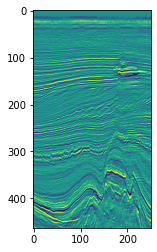

In [2]:
import matplotlib.pyplot as plt

plt.imshow(seismic[5].T)

## Complex trace attributes

### Envelope (aka reflection strength, instantaneous amplitude)

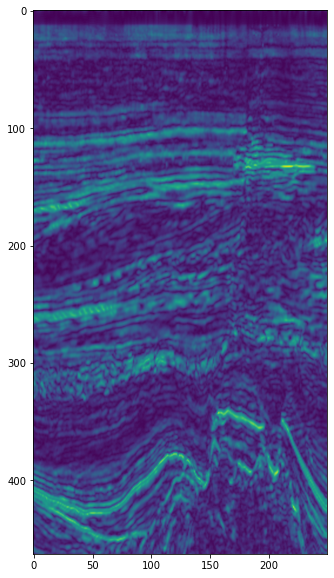

In [3]:
import bruges as bg

env = bg.attribute.envelope(seismic)

plt.figure(figsize=(6, 10))
plt.imshow(env[5].T, interpolation='bicubic')

### Instantaneous phase

We'll display this with a circular colourmap, and turn off interpolation to preven visualization artifacts. 

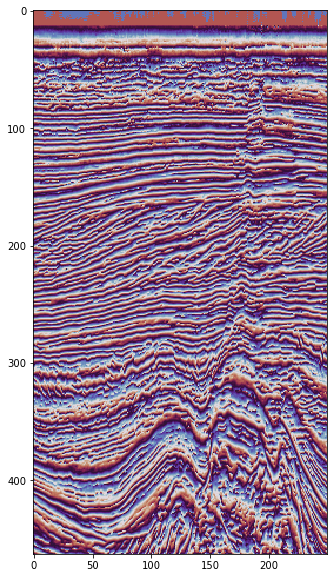

In [23]:
phase = bg.attribute.instantaneous_phase(seismic)

plt.figure(figsize=(6, 10))
plt.imshow(phase[5].T, cmap='twilight_shifted', interpolation='none')

### Instantaneous frequency

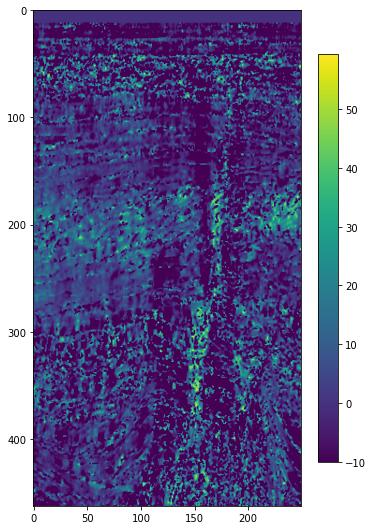

In [24]:
freq = bg.attribute.instantaneous_frequency(seismic, dt=0.004)

plt.figure(figsize=(6, 10))
plt.imshow(freq[5].T, interpolation='bicubic', vmin=-10)
plt.colorbar(shrink=0.75)

### Similarity (family including coherency, semblance, gradient structure tensor, etc.)

⚠️ This one takes quite a bit longer than the simpler attributes above (about a minute on my machine), so you might want to experiment on a subcube before computing the entire volume.

In [28]:
semb = bg.attribute.similarity(seismic, duration=0.036, dt=0.004, kind='gst')

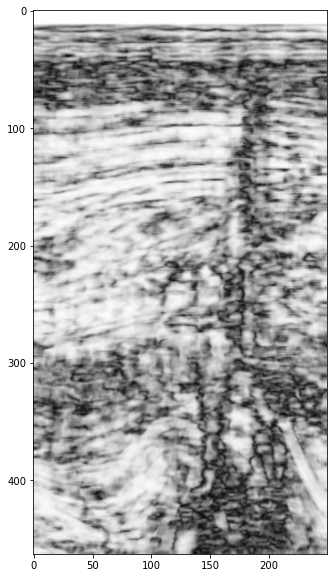

In [29]:
plt.figure(figsize=(6, 10))
plt.imshow(semb[5].T, cmap='gray', interpolation='bicubic')

## Windowed attribute statistics

Let's say we'd like to compute the mean amplitude over a dataset, but inside a running window.

The easiest way to accomplish this is with `scipy.ndimage.generic_filter()`. It's nice because it handles the mechanics of stepping over the array.

This wants a so-called 'callback' function, to which each sub-volume will be passed. Let's see:

In [30]:
def rms(data):
    """
    Root mean square.
    
    Example
    >>> rms([3, 4, 5])
    4.08248290463863
    """
    data = np.asanyarray(data)
    return np.sqrt(np.sum(data**2) / data.size)

**`generic_filter`** wants the data, the function, and the **`size`** of the sub-volume to pass in to the callback function. This can be trace-by-trace (use **1** for the first two dimensions) or multi-trace (e.g. use 3). A larger template will be slower to compute of course.

In [15]:
from scipy.ndimage import generic_filter

seismic_rms = generic_filter(seismic, rms, size=(1, 1, 11))
seismic_rms.shape

(225, 300, 463)

The shape is the same as the original dataset. That's convenient.

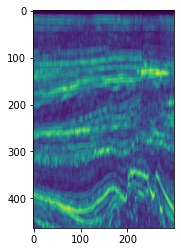

In [16]:
plt.imshow(seismic_rms[5].T)

### Other statistics

To get other statistics, we just need to change the function, or simply pass in a function from NumPy or wherever, eg:

```python
seismic_median = generic_filter(seismic, np.median, size=(3, 3, 11))
```

Gives a median filter computed over a kernel with shape 3 &times; 3 inlines by crosslines, and 11 time samples.

### Faster, but fiddly-er

For the trace-by-trace case, we could speed this up by computing the RMS over various shifted versions of the seismic. This does not need more memory, because the shifted cubes are just views of the data. However, it does mean that the result will be shorter than the input, unless we somehow deal with the boundaries.

For a window of length `n`, we can make a set of shifted views of the volume:

In [17]:
n = 11
vols = [seismic[:, :, ni:ni-n] for ni in range(n)]

Then compute the RMS over this collection; on my computer this is about 200 times faster than the `generic_filter` approach above (900 ms vs 3 minutes):

In [18]:
data = np.asanyarray(vols)
seismic_rms = np.sqrt(np.sum(data**2, axis=0) / n)

Note that the result is not the same shape as the data, however:

In [19]:
seismic_rms.shape

(225, 300, 452)

Note that this volume has 5 samples 'missing' at the top, and another 5 at the bottom.

Also, this method won't work for multi-trace statistics. So `generic_filter` is probably the best general approach.

## Attributes and `xarray`

Let's look at how to make this into an `xarray.DataArray`:

In [8]:
import xarray as xr

# I don't have the inline, xline numbers, so I'll just use the shape.
i, x, t = env.shape
iline = np.arange(i)
xline = np.arange(x)
twt = np.arange(t) * 0.004

env_xr = xr.DataArray(env,
                      name='envelope',
                      coords=[iline, xline, twt],
                      dims=['iline', 'xline', 'twt'],
                      )

This makes lots of things easier, like plotting:

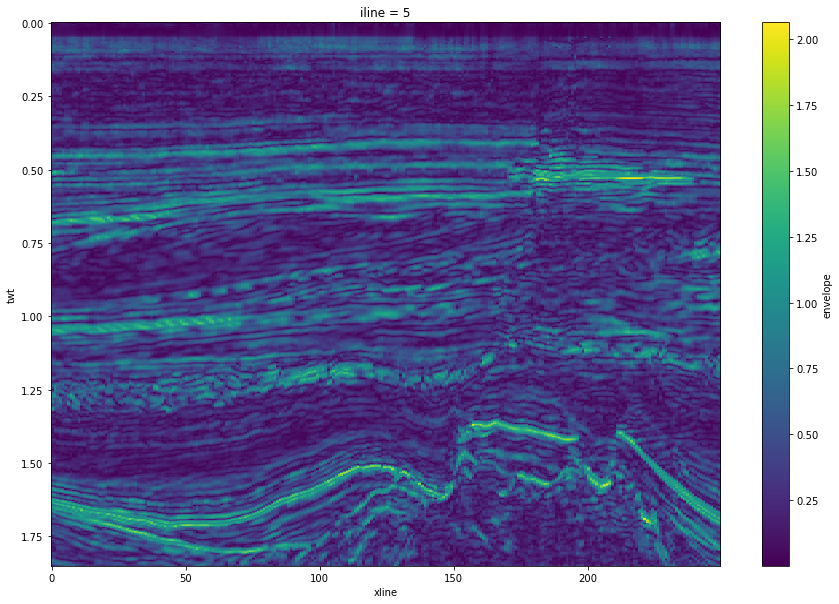

In [9]:
plt.figure(figsize=(15, 10))
env_xr[5].T.plot.imshow(origin='upper')

---

&copy; Agile Scientific 2021 &mdash; licensed CC BY / Apache 2.0